In [1]:
%matplotlib notebook
import matplotlib as mpl
import itertools
import PyVal
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook, tqdm, tqdm_gui
from functools import reduce
from scipy.stats import norm as normalDist
from scipy.stats import multivariate_normal as MVNormalDist
from matplotlib.lines import Line2D
from numpy.linalg import inv as m_inv
import matplotlib
import ipywidgets as widgets

In [144]:
from numba import double, int32, jit
from numba.types import UniTuple

def fp_num(M_, a_, d_):
    max_it = 10
    N = 2
    x = np.ones(2*N)
    for i in range(max_it):
        x2 = a_ + M_.dot(x)
        s = np.maximum(np.repeat(0.,N), x2 - d_)
        r = np.minimum(d_, x2)
        x = np.append(s, r)
        #if np.linalg.norm(x - x_n) < 1e-8:
        #    return x_n
        #x = x_n
    return x
fp_num_2 = jit(double[:](double[:,:], double[:], double[:]))(fp_num)

def gen_St(r, T, sigma_, Z):
    N = sigma_.shape[0]
    m = T * r - T * np.diag(sigma_)/ 2.
    return np.exp(m + np.sqrt(T) * np.diag(np.sqrt(sigma_)) * Z)

gen_St_2 = jit(double[:,:](double, double, double[:,:], int32))(gen_St)


def jac(M_, x_, d_):
    N = 2
    v = x_[:N] + x_[N:]
    solvent = 1.*(v >= d_)
    J_a = np.zeros((2*N,N))
    J_a[:N,:][np.diag_indices(N)] = solvent
    J_a[N:,:][np.diag_indices(N)] = 1. - solvent
    invJ = m_inv(np.eye(2*N) - J_a.dot(M))
    return invJ.dot(J_a)

jac_2 = jit(double[:,:](double[:,:], double, double))(jac)


def run_MC(M_, a_, d_, r_, T_, sigma_, N_MC_):
    N = 2
    x = np.zeros(2*N)
    delta = np.zeros((2*N, N))
    vega = np.zeros((2*N, N))
    rho = np.zeros(2*N)
    theta = np.zeros(2*N)
    Z = MVNormalDist.rvs(mean = np.zeros(N), cov = np.eye(N), size=N_MC_)
    St = gen_St_2(r_, T_, sigma_, Z)
    exprt = np.exp(-r_*T_)
    for i in range(N_MC_):
        St_full = a_*St[i]
        x_i = fp_num_2(M_, St_full, d_)
        gm_i = jac_2(M_, x_i, d_)
        x += x_i
        delta += exprt*gm_i.dot(np.diag(St[i]))
        
        tmp_vega_1 = np.sqrt(T)*Z[i] - T*np.sqrt(np.sqrt(np.diag(sigma_))) #
        #print(tmp1)
        #print(St_full)
        #print(np.outer(tmp1, St_full))
        #print(gm_i.shape)
        tmp_vega_2 = tmp_vega_1.dot(St_full)
        vega += exprt*gm_i.dot(tmp_vega_2)
        tmp_theta_1 = r - sigma_/2. + np.diag(Z[i]/(2.*np.sqrt(T_)))
        tmp_theta_2 = tmp_theta_1.dot(St[i])
        theta += exprt*(gm_i.dot(tmp_theta_2) - r_*x_i)
        rho += exprt*T_*(gm_i.dot(St_full) - x_i)
    return x/N_MC_, delta/N_MC_, vega/N_MC_, theta/N_MC_, rho/N_MC_

run_MC_2 = jit(UniTuple(double[:,:], 2)(double[:,:], double[:], double[:], double, double, double[:,:], int32))(run_MC)

In [137]:
N = 2
r = 0.
T = 1.
sdev = 0.1
sigma = np.array([[sdev*sdev, 0.],[0.,sdev*sdev]])

M = np.array([[0., 0., 0., 0.4],[0.,0., 0.4, 0.]])
al = np.linspace(0.4,1.2, 10)
d = np.array([1.0, 1.0])

N_MC = 6000

In [138]:
res_x = []
res_delta = []
res_vega = []
res_theta = []
res_rho = []
for a0 in tqdm(al,"test"):
    x, delta, vega, theta, rho = run_MC(M, a0, d, r, T, sigma, N_MC)
    res_x.append(x)
    res_delta.append(delta)
    res_vega.append(vega)
    res_theta.append(theta)
    res_rho.append(rho)

test: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


In [139]:
rr = np.array(res_delta)
eq_delta = np.sum(rr[:,:N,:], axis=(1,2))/N
debt_delta = np.sum(rr[:,N:,:], axis=(1,2))/N

rr = np.array(res_vega)
eq_vega = np.sum(rr[:,:N,:], axis=(1,2))/N
debt_vega = np.sum(rr[:,N:,:], axis=(1,2))/N

rr = np.array(res_theta)
eq_theta = np.sum(rr[:,:N], axis=1)/N
debt_theta = np.sum(rr[:,N:], axis=1)/N

rr = np.array(res_rho)
eq_rho = np.sum(rr[:,:N], axis=1)/N
debt_rho = np.sum(rr[:,N:], axis=1)/N

<IPython.core.display.Javascript object>


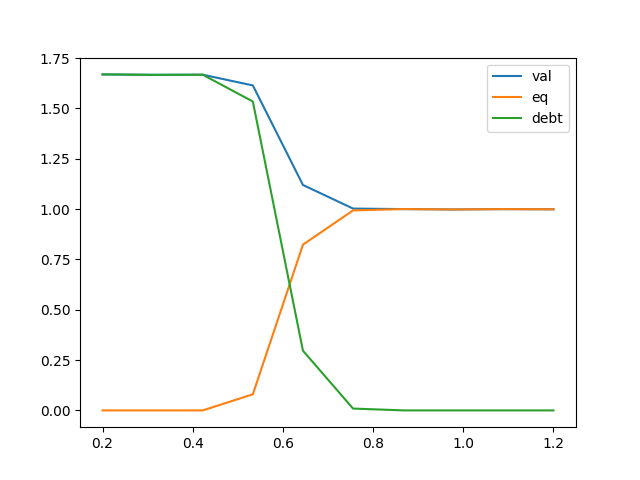

In [140]:
plt.figure()
plt.plot(al, eq_delta + debt_delta, label="val")
plt.plot(al, eq_delta, label="eq")
plt.plot(al, debt_delta, label="debt")
plt.legend()

<IPython.core.display.Javascript object>


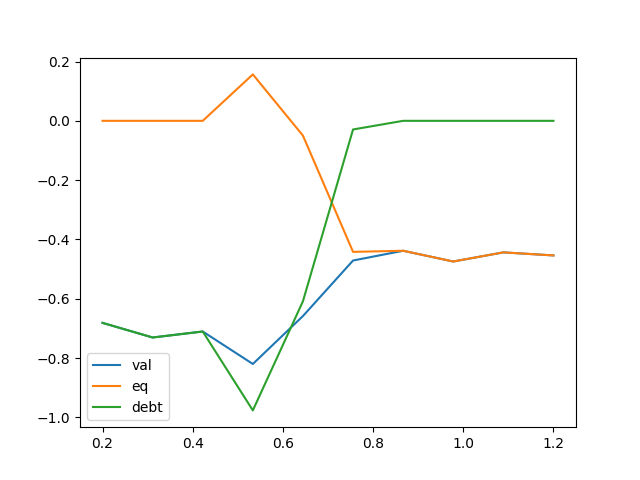

In [141]:
plt.figure()
plt.plot(al, eq_vega + debt_vega, label="val")
plt.plot(al, eq_vega, label="eq")
plt.plot(al, debt_vega, label="debt")
plt.legend()

<IPython.core.display.Javascript object>


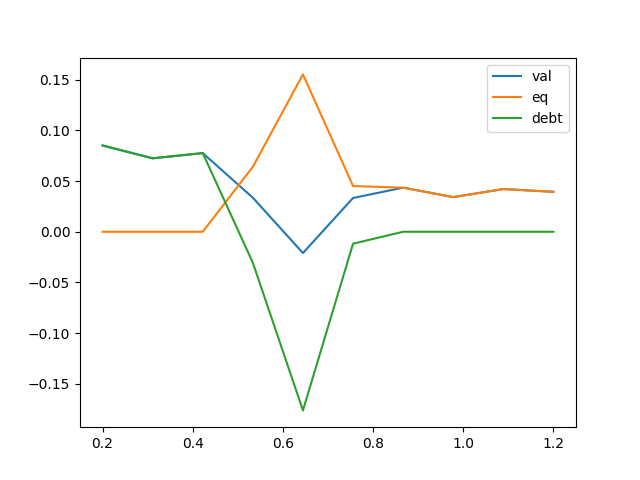

In [142]:
plt.figure()
plt.plot(al, eq_theta + debt_theta, label="val")
plt.plot(al, eq_theta, label="eq")
plt.plot(al, debt_theta, label="debt")
plt.legend()

<IPython.core.display.Javascript object>


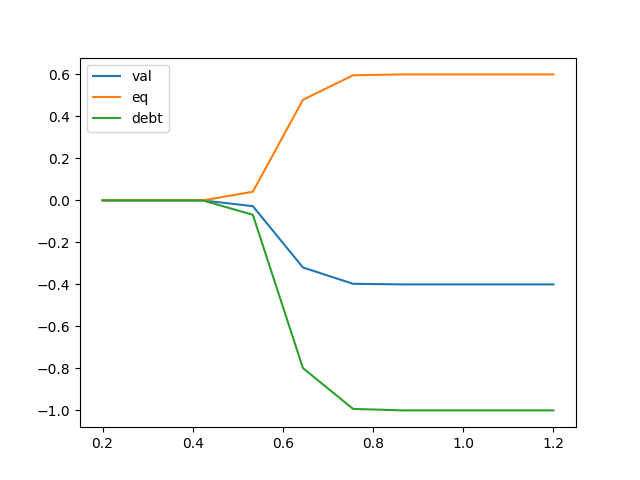

In [143]:
plt.figure()
plt.plot(al, eq_rho + debt_rho, label="val")
plt.plot(al, eq_rho, label="eq")
plt.plot(al, debt_rho, label="debt")
plt.legend()